In [4]:
from typing import Dict
from time import perf_counter_ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import quimb.tensor as qtn
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import TensorNetAdapt, LinAlgAdapt
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.tensor_helpers import pauli_sum_to_mpo

In [5]:
max_mpo_bond = 100
system_size = 4
max_mps_bonds = [1, 4, 8]
l = system_size

dmrg_energies: Dict[int, float] = {}
for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, chi)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At chi={chi} got energy {ground_energy}.")
    dmrg_energies[chi] = ground_energy

At chi=1 got energy (-2.170820393249935+6.661338147750939e-16j).
At chi=4 got energy (-6.464101615137774-8.881784197001252e-16j).
At chi=8 got energy (-6.464101615137758-6.661338147750939e-16j).


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


In [6]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, system_size)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=system_size, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=30,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=chi
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For chi={chi} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[chi] = tn_adapt.energy
    adapt_runtimes[chi] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 26: -4.000000000000003
Operator 27: 4.000000000000003
Operator 30: -4.000000000000003
Operator 31: 4.000000000000003
Operator 74: 4.000000000000003
Operator 75: -4.000000000000003
Operator 78: 4.000000000000003
Operator 79: -4.000000000000003
Operator 134: 4.000000000000012
Operator 135: -4.000000000000012
Operator 146: -4.000000000000012
Operator 147: 4.000000000000012
Operator 161: -4.000000000000005
Operator 164

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.000000
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.742662583825165e-08
Operator 4: -6.742662583825165e-08
Operator 16: 1.4555409855177004e-07
Operator 21: 1.4555409855177004e-07
Operator 26: 1.1184078718695645e-07
Operator 27: -2.0000000000000018
Operator 30: 2.0000000000000018
Operator 31: -1.1184078718695645e-07
Operator 38: 3.371330903334524e-08
Operator 39: 2.0000000000000053
Operator 45: -2.0000000000000053
Operator 54: -2.0000000000000044
Operator 55: -3.371330759005531e-08
Operator 57: 2.0000000000000044
Operator 64: -1.4555409821870313e-07
Operator 69: -1.4555409788563622e-07
Operator 74: -1.1184078718695645e-07
Operator 75: 2.0000000000000018
Operator 78:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.327276
         Iterations: 6
         Function evaluations: 44
         Gradient evaluations: 33

Current energy: -6.327276154819943
(change of -0.20417052920230994)
Current ansatz: [244, 26, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 3.9967108999769407e-07
Operator 4: -4.6213638187422856e-07
Operator 16: 2.2095586974316128e-07
Operator 21: 1.5849057786836152e-07
Operator 26: 1.0859613122811418e-07
Operator 27: 2.6780628181489876e-07
Operator 30: -0.7090339180190619
Operator 31: -7.651266834256959e-08
Operator 38: 1.0199241702070483e-07
Operator 39: 2.089491575696501
Operator 41: 6.855105595497679e-08
Operator 45: -2.0894899823758935
Operator 54: 0.7090386134772628
Operator 55: -2.7287187834160523e-07
Operator 57: -6.556585103511378e-06
Operator 61: 1.908942402137348e-07
Operator 64: -1.5849057875827466e-07
Operator 69: -2.209558704127

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.000000
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.742662583825165e-08
Operator 4: -6.742662583825165e-08
Operator 16: 1.4555409855177004e-07
Operator 21: 1.4555409855177004e-07
Operator 26: 1.1184078718695645e-07
Operator 27: -2.0000000000000018
Operator 30: 2.0000000000000018
Operator 31: -1.1184078718695645e-07
Operator 38: 3.371330903334524e-08
Operator 39: 2.0000000000000053
Operator 45: -2.0000000000000053
Operator 54: -2.0000000000000044
Operator 55: -3.371330759005531e-08
Operator 57: 2.0000000000000044
Operator 64: -1.4555409821870313e-07
Operator 69: -1.4555409788563622e-07
Operator 74: -1.1184078718695645e-07
Operator 75: 2.0000000000000018
Operator 78:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.327276
         Iterations: 6
         Function evaluations: 64
         Gradient evaluations: 52

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [244, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -9.696849519180706e-08
Operator 4: 9.696849723184187e-08
Operator 16: 3.8949733358745187e-08
Operator 21: 3.8949732793225333e-08
Operator 26: 7.403554321341876e-08
Operator 27: 6.571718700419847e-06
Operator 30: -0.7090369775226198
Operator 31: -5.539007416274777e-08
Operator 38: -6.716676784201958e-08
Operator 39: 2.089489963107958
Operator 45: -2.0894929267350784
Operator 54: 0.7090282438171777
Operator 57: 5.125613860897287e-06
Operator 61: 1.600408327737113e-08
Operator 64: -3.8949732793225333e-08
Operator 69: -3.894973308118943e-08
Operator 74: -5.539007457214251e-08
Operator 75: -0.7090369775226196


In [7]:
records = []
for chi in max_mps_bonds:
    records.append((chi, dmrg_energies[chi], adapt_energies[chi], adapt_runtimes[chi]))
df = pd.DataFrame.from_records(records, columns=["chi", "dmrg_energy", "adapt_energy", "adapt_runtime"])
df.to_csv("../data/xxz_energy_vs_bond.csv")

In [11]:
df["error"] = np.abs(df['dmrg_energy'] - df["adapt_energy"])

In [12]:
print(df.head())

   chi         dmrg_energy  adapt_energy  adapt_runtime         error
0    1 -2.170820+0.000000j     -3.000000     7731500167  8.291796e-01
1    4 -6.464102-0.000000j     -6.464102     9299138750  4.561516e-10
2    8 -6.464102-0.000000j     -6.464102    10268710041  4.909602e-10


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\chi$')

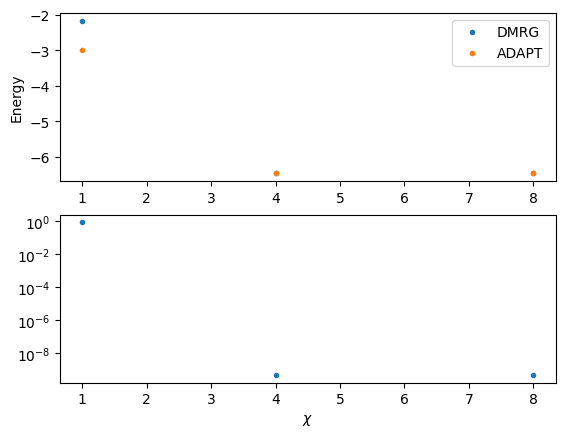

In [13]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df["chi"], df["dmrg_energy"], '.', label="DMRG")
ax[0].plot(df["chi"], df["adapt_energy"], '.', label="ADAPT")
ax[0].legend()
ax[0].set_ylabel("Energy")
ax[1].plot(df["chi"], df["error"], '.')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\chi$")